# H6752 - Data Extraction Techniques Group Project
## Extraction of SMRT Tweets

In [1]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup as bs

### Use either Firefox or Chrome to load the webpages
browser = webdriver.Firefox()
#browser = webdriver.Chrome()

### URL to scrap
url = "https://twitter.com/smrt_singapore?lang=en"

browser.get(url)

In [2]:
### Selenium script to auto scroll to the end of page, with interval of 3 seconds between scroll.
### For purpose of testing, skip this part of code.

#from selenium import webdriver
#browser = webdriver.Firefox()
#browser.get("https://twitter.com/smrt_singapore?lang=en")
lenOfPage = browser.execute_script("window.scrollTo(0, document.body.scrollHeight); \
                                var lenOfPage=document.body.scrollHeight;return lenOfPage;")
match=False
while(match==False):
    lastCount = lenOfPage
    time.sleep(3)    # pause for 3 seconds before next scroll
    lenOfPage = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);\
                                var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    if lastCount==lenOfPage:
        match=True

In [3]:
### Scrap the HTML after fully load the web page and load into BeautifulSoup.

source_data = browser.page_source
bs_data = bs(source_data, "lxml")

In [4]:
### Verify data extraction for one tweet is correct.

article_info = bs_data.find("p", {"class": 'TweetTextSize TweetTextSize--normal js-tweet-text tweet-text'})
print(article_info.text)

article_info = bs_data.find('a', {'class': 'tweet-timestamp js-permalink js-nav js-tooltip' })['title']
print (article_info)

All 35 EWL stns from Tuas Link to Pasir Ris & from Tanah Merah to Changi Airport will have shorter operational hrs every weekend from 6 to 29 April. Shuttle bus svcs will be available between the stns. Plan ahead & take other train lines and bus svcs. https://bit.ly/2Gvq1Br pic.twitter.com/u47bY0op8M
2:38 AM - 2 Apr 2018


In [5]:
### Verify REGEX pattern extracts correctly

import re

# Sample tweet
s = '[NSL] CLEARED: Train svc from #YewTee to #JurongEast is running normally now.'

repatt = r'[\bbetween\b|\bbtwn\b|\bfrom\b] \#(\w*)[\s\w]*[and|to|&]*[\s]*\#[\s]*(\w*)'
#repatt = r"\bCLEARED\b|\bcleared\b|\bCleared\b|\bhave resume\b|\bhave resumed\b|\bhas resumed\b|\bservice resumed\b|\bnormal\b|\bnormally\b|\bceased\b|\bcease\b"    # indication that fault is cleared or services is resumed
#repatt = r'\bEWL\b|\bNSL\b|\bCCL\b'
#repatt  = r'[F|f][ree][\w\s\d\&\#]*end'

extract = re.search(repatt, s)
if extract:  
    print ("From: %s  To: %s\n" % (extract.group(1), extract.group(2))) 
    #print (extract.group(0))
else:
    print("Extraction Error")

From: YewTee  To: JurongEast



In [6]:
### Actual script to extract all the relevant data (tweets, date/time, Station Names, MRT Status)

from datetime import datetime
import re

article_infoAll = bs_data.find_all("div", {"class": 'content'})

smrt_tweet_data = []  # list container to hold all extracted SMRT tweet

### Regex extraction pattern
### ========================
re_mrtline = r'^[\[]*(\bNSL\b|\bEWL\b|\bCCL\b|\bBPLRT\b|\bDTL\b)'
re_mrtstatus = r'\bCLEARED\b|\bcleared\b|\bCleared\b|\bhave resume\b|\bhave resumed\b|\bhas resumed\b|\bservice resumed\b|\bnormal\b|\bnormally\b|\bceased\b|\bcease\b'    # indication that fault is cleared or services is resumed
re_patt = r'[F|f][ree][\w\s\d\&\#]*ended'
re_stn = r'[\bbetween\b|\bbtwn\b|\bfrom\b] \#(\w*)[\s\w]*[and|to|&]*[\s]*\#[\s]*(\w*)'

for item in article_infoAll:
    
    tweet_row = [] # list container to hold extracted tweet info for each SMRT tweet
    
    try:

        ### Extract tweet body from html
        ### ============================
        tweet_body = item.find("p", {"class": 'TweetTextSize TweetTextSize--normal js-tweet-text tweet-text'})
        tweet_row.append(tweet_body.text)

        ### Extract date and time from the html
        ### ===================================
        tweet_datetime = item.find('a', {'class': 'tweet-timestamp js-permalink js-nav js-tooltip' })['title']
        tweet_row.append(tweet_datetime)
        
        ### Convert extract tweet_datetime into datetime object so that it can be calculated
        ### =======================================
        date = datetime.strptime(tweet_datetime, '%I:%M %p - %d %b %Y')
        print("Converted date/time: %s" % date)
        tweet_row.append(date)        
        
        ### ================================================================================
        ### If tweet starts with [xxx], it indicate the tweet had MRT status information
        ### Extract tweet using regex to determine status type, i.e.'cleared', 'update', 'ok'
        ### ================================================================================
        
        ### Extract and check if tweet starts with [xxx]
        ### ============================================
        mrtline = re.search(re_mrtline, tweet_body.text)
        
        if mrtline:  # if the tweet starts with [XXX], then it is a status tweet
            ### Extract MRT Line inside []
            ### ==========================
            print("Extracted MRT Line: " + mrtline.group(1))
            tweet_row.append(mrtline.group(1))
            
            ### Extract MRT Line status based on keywords
            ### =========================================
            mrtstatus = re.search(re_mrtstatus, tweet_body.text)
            if mrtstatus:   # if is status is stated 'cleared' in tweeter
                print("Status: Cleared") 
                print("Extracted tweet: %s\n" % tweet_body.text)
                tweet_row.append('cleared')
            else:
                patt=re.search(re_patt, tweet_body.text)
                if patt:    # check if there are other indicators that inferred as 'cleared'. Such as 'Free ... ended'.
                    print("Status: Cleared") 
                    print("Extracted tweet: %s\n" % tweet_body.text)
                    tweet_row.append('cleared')
                else:       # if is a status tweet but no 'cleared' status, then the tweet will be a disruption status.
                    print("Status: Update")
                    print("Extracted tweet: %s" % tweet_body.text.replace('\n','')) # some tweet has newline
                    tweet_row.append('update')
                
                    ### Extract station names
                    ### =====================
                    stn = re.search(re_stn, tweet_body.text)
                    if extract:
                        print ("From: %s  To: %s\n" % (stn.group(1), stn.group(2)))  
                        tweet_row.append(stn.group(1))   # from station
                        tweet_row.append(stn.group(2))   # to station

        else:    # if no mrt line mention in [xxx] format, then it is a normal information tweets.
            tweet_row.append('None')
            tweet_row.append('ok')
            print('Status: OK')
            print('Extracted tweet: %s\n' % tweet_body.text)   # for checking only
        
        ### Store the extracted tweet info into the list container
        smrt_tweet_data.append(tweet_row)
        
    except:
        print("Extraction Error!\n")
        continue

Converted date/time: 2018-04-02 02:38:00
Status: OK
Extracted tweet: All 35 EWL stns from Tuas Link to Pasir Ris & from Tanah Merah to Changi Airport will have shorter operational hrs every weekend from 6 to 29 April. Shuttle bus svcs will be available between the stns. Plan ahead & take other train lines and bus svcs. https://bit.ly/2Gvq1Br pic.twitter.com/u47bY0op8M

Converted date/time: 2018-03-08 00:53:00
Status: OK
Extracted tweet: Gentle reminder that svc improvement has been made to shuttle bus svc 6 for better connectivity. Shuttle bus svc 6 will now be extended to ply from Raffles Place to Paya Lebar stns (both bounds). http://bit.ly/2oyza4d pic.twitter.com/22CPlP1JYR

Converted date/time: 2018-03-08 00:44:00
Status: OK
Extracted tweet: All EWL stns from Tuas Link to Pasir Ris & from Tanah Merah to Changi Airport will have shorter operational hrs every weekend & selected weekdays from 2 Mar to 1 Apr.Shuttle bus svcs will be avail btwn the stns.Plan ahead & take other train lin


Converted date/time: 2017-11-15 12:43:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL]:Train svc btwn #JooKoon & #TuasLink is suspended. Free regular & bridging bus svcs are available btwn #JooKoon & #TuasLink all day.
From: JooKoon  To: TuasLink

Converted date/time: 2017-11-15 06:18:00
Extracted MRT Line: NSL
Status: Cleared
Extracted tweet: [NSL] update: Train service on North South Line has running normally now.

Converted date/time: 2017-11-15 04:33:00
Extracted MRT Line: NSL
Status: Update
Extracted tweet: [NSL] UPDATE: Due to fewer trains serving the NSL tmr, pls add 40mins train travel time. Free bridging bus svcs from #Yishun to #MarinaSouthPier (one way) and free regular bus svcs between #Yishun and #MarinaSouthPier (both directions) are avail from the start of train service.
From: Yishun  To: MarinaSouthPier

Converted date/time: 2017-11-15 04:29:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL]UPDATE:Train svcs btwn #JooKoon & #TuasLink will 

Extracted MRT Line: EWL
Status: Cleared
Extracted tweet: [EWL] UPDATE: Train svcs has resumed. Pls add 20mins travel time btwn #Tampines and #PasirRis due to track point fault.

Converted date/time: 2017-09-27 14:58:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL] UPDATE: Free regular bus svcs btwn #Tampines and #PasirRis.
From: Tampines  To: PasirRis

Converted date/time: 2017-09-27 14:54:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL] UPDATE: Free regular bus svcs btwn #TanahMerah and #PasirRis.
From: TanahMerah  To: PasirRis

Converted date/time: 2017-09-27 14:53:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL]:Due to track point fault,pls expect 30mins delay train travel time btwn TanahMerah & PasirRis.(Not linked to new signalling project).
Extraction Error!

Converted date/time: 2017-09-15 07:09:00
Extracted MRT Line: NSL
Status: Cleared
Extracted tweet: [NSL] CLEARED: Train svcs btwn #MarinaSouthPier and #ToaPayoh have resumed. Fr

Status: Update
Extracted tweet: [NSL] UPDATE: Free bus services are still available on the #NSL.
Extraction Error!

Converted date/time: 2017-06-28 03:51:00
Status: OK
Extracted tweet: Check our bus guides at https://smrt.com.sg/Journey-with-Us/Trains/Alternative-Travel-Options … … for details on bus services.

Converted date/time: 2017-06-28 03:32:00
Extracted MRT Line: NSL
Status: Update
Extracted tweet: [NSL] UPDATE: Please add about 15 mins travel time on the #NSL. Train services between #JUR and #MSP are running both bounds.
From: JUR  To: MSP

Converted date/time: 2017-06-28 03:10:00
Extracted MRT Line: NSL
Status: Update
Extracted tweet: [NSL] UPDATE: Train services on the #NSL will be delay for 30 mins. Free regular bus services are still available on the #NSL.
Extraction Error!

Converted date/time: 2017-06-28 02:56:00
Extracted MRT Line: EWL
Status: Cleared
Extracted tweet: [EWL] UPDATE: Train services btw #JKN and #TLK have resumed. Free bus services are still available betw

Extracted tweet: [BPLRT Update] Faulty train is being recovered. Normal train services will resume in around 10 min.
Extraction Error!

Converted date/time: 2017-02-09 23:26:00
Extracted MRT Line: BPLRT
Status: Update
Extracted tweet: [BPLRT] Train services on BPLRT affected due to a train fault. Free regular bus services are available along BPLRT.
Extraction Error!

Converted date/time: 2017-02-09 16:51:00
Extracted MRT Line: NSL
Status: Cleared
Extracted tweet: [NSL] CLEARED: Train services from #Newton towards #MarinaSouthPier have resumed. Free regular bus services have ceased.

Converted date/time: 2017-02-09 16:30:00
Extracted MRT Line: NSL
Status: Cleared
Extracted tweet: [NSL] UPDATE: Fault cleared. Free regular bus services are still available between #Newton & #RafflesPlace.

Converted date/time: 2017-02-09 16:27:00
Extracted MRT Line: NSL
Status: Cleared
Extracted tweet: [NSL]UPDATE:Fault cleared,trains are progressively returning to normal speed.

Converted date/time: 2017-

Extracted tweet: [EWL] UPDATE: Free regular bus services are available between #Queenstown and #JurongEast. Updated resumption time at 7:30am.
From: Queenstown  To: JurongEast

Converted date/time: 2016-10-20 16:01:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL]: Due to a train fault, pls add 20 mins travel time from #Queenstown to #JurongEast towards #JooKoon. Train service is still available.
From: Queenstown  To: JurongEast

Converted date/time: 2016-10-18 06:03:00
Extracted MRT Line: EWL
Status: Cleared
Extracted tweet: [EWL] CLEARED: Normal train service has resumed from #TanahMerah to #Bugis.

Converted date/time: 2016-10-18 05:38:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL]UPDATE:Additional travel time has been reduced to 5mins from #TanahMerah to #Bugis. Train svc is still available.
From: TanahMerah  To: Bugis

Converted date/time: 2016-10-18 05:27:00
Extracted MRT Line: EWL
Status: Update
Extracted tweet: [EWL]UPDATE:Additional travel time

In [7]:
### Tabulate all the extracted data into table using panda
import pandas as pd

df = pd.DataFrame(smrt_tweet_data, columns=['Tweet', 'Extracted Date/Time', 'Date/Time', 'MRT_Line', 'Status', 'From_Stn', 'To_Stn'])

df.head(10)

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn
0,All 35 EWL stns from Tuas Link to Pasir Ris & ...,2:38 AM - 2 Apr 2018,2018-04-02 02:38:00,None,ok,None,None
1,Gentle reminder that svc improvement has been ...,12:53 AM - 8 Mar 2018,2018-03-08 00:53:00,None,ok,None,None
2,All EWL stns from Tuas Link to Pasir Ris & fro...,12:44 AM - 8 Mar 2018,2018-03-08 00:44:00,None,ok,None,None
3,Here’s a sneak peek of our SMRT’s new uniforms...,8:02 PM - 3 Mar 2018,2018-03-03 20:02:00,None,ok,None,None
4,All EWL stns from Tuas Link to Pasir Ris & fro...,3:19 AM - 1 Mar 2018,2018-03-01 03:19:00,None,ok,None,None
5,Track improvement works in the North-South Lin...,3:26 AM - 19 Feb 2018,2018-02-19 03:26:00,None,ok,None,None
6,[NSL] CLEARED: Train svcs from #AngMoKio to #R...,6:17 PM - 18 Feb 2018,2018-02-18 18:17:00,NSL,cleared,None,None
7,[NSL] UPDATE: Due to on going track improvemen...,6:01 PM - 18 Feb 2018,2018-02-18 18:01:00,NSL,update,AngMoKio,RafflesPlace
8,[NSL] : Due to on going track improvement work...,4:29 PM - 18 Feb 2018,2018-02-18 16:29:00,NSL,update,AngMoKio,RafflesPlace
9,Wishing everyone a Happy and Prosperous Lunar ...,8:01 AM - 15 Feb 2018,2018-02-15 08:01:00,None,ok,None,None


In [8]:
### Number of SMRT tweets extracted
df.shape

(710, 7)

In [9]:
### Save all extracted tweets into csv
df.to_csv("smrt_tweet_extract.csv")

In [10]:
### Clean up the data
### Remove 'ok' status to focus on tweet with status

df = df[df.Status != 'ok']

df.head(10)   

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn
6,[NSL] CLEARED: Train svcs from #AngMoKio to #R...,6:17 PM - 18 Feb 2018,2018-02-18 18:17:00,NSL,cleared,None,None
7,[NSL] UPDATE: Due to on going track improvemen...,6:01 PM - 18 Feb 2018,2018-02-18 18:01:00,NSL,update,AngMoKio,RafflesPlace
8,[NSL] : Due to on going track improvement work...,4:29 PM - 18 Feb 2018,2018-02-18 16:29:00,NSL,update,AngMoKio,RafflesPlace
10,[NSL] CLEARED: Train svcs from #AngMoKio to #R...,6:07 PM - 13 Feb 2018,2018-02-13 18:07:00,NSL,cleared,None,None
11,"[NSL Update]: Due to maintenance work, trains ...",5:04 PM - 13 Feb 2018,2018-02-13 17:04:00,NSL,update,AngMoKio,Raffles
12,"[NSL]: Due to maintenance work, south-bound tr...",1:45 PM - 13 Feb 2018,2018-02-13 13:45:00,NSL,update,AngMoKio,RafflesPlace
13,"[NSL] UPDATE: Fault cleared, train svcs from #...",6:38 PM - 6 Feb 2018,2018-02-06 18:38:00,NSL,cleared,None,None
14,[NSL] UPDATE: Due to on going track improvemen...,6:04 PM - 6 Feb 2018,2018-02-06 18:04:00,NSL,update,AngMoKio,RafflesPlace
15,"[NSL] UPDATE: Fault cleared, train svcs are pr...",5:18 PM - 6 Feb 2018,2018-02-06 17:18:00,NSL,cleared,None,None
16,"[NSL] UPDATE: Fault cleared, train svcs are pr...",4:46 PM - 6 Feb 2018,2018-02-06 16:46:00,NSL,cleared,None,None


In [11]:
### Number of tweets with MRT Line status update
df.shape

(583, 7)

In [12]:
### Sort dataframe according to MRT line (ascending) and Date/time (descending)
### This will help in the calculation of disruption duration
df.sort_values(['MRT_Line', 'Date/Time'], ascending=[True, False], inplace=True)

df.head(10)  

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn
20,[BPLRT] Fault cleared. Normal train services a...,12:54 AM - 18 Jan 2018,2018-01-18 00:54:00,BPLRT,cleared,None,None
21,[BPLRT]: No train service between #ChoaChuKang...,12:12 AM - 18 Jan 2018,2018-01-18 00:12:00,BPLRT,update,ChoaChuKang,Phoenix
22,[BPLRT] CLEARED: Free regular and bridging bus...,3:09 AM - 12 Jan 2018,2018-01-12 03:09:00,BPLRT,cleared,None,None
23,[BPLRT] UPDATE: Train services on the entire B...,2:30 AM - 12 Jan 2018,2018-01-12 02:30:00,BPLRT,cleared,None,None
24,[BPLRT] UPDATE: Service B on the BPLRT inner l...,2:04 AM - 12 Jan 2018,2018-01-12 02:04:00,BPLRT,cleared,None,None
165,[BPLRT] CLEARED: Free bus and bridging bus ser...,1:45 AM - 9 Sep 2017,2017-09-09 01:45:00,BPLRT,cleared,None,None
166,[BPLRT] CLEARED: Normal service on the BPLRT h...,1:25 AM - 9 Sep 2017,2017-09-09 01:25:00,BPLRT,cleared,None,None
203,[BPLRT]\nCLEARED: Train services on the Servic...,11:56 PM - 11 Aug 2017,2017-08-11 23:56:00,BPLRT,cleared,None,None
205,[BPLRT]\nCLEARED: Train services on the Servic...,2:15 AM - 27 Jul 2017,2017-07-27 02:15:00,BPLRT,cleared,None,None
206,[BPLRT]\nUPDATE: Train fault between #Senja an...,2:05 AM - 27 Jul 2017,2017-07-27 02:05:00,BPLRT,update,Senja,Jelapang


In [13]:
### Re-index the dataframe to prepare to calculate disruption duration
df = df.reset_index(drop=True)
df.head(10)

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn
0,[BPLRT] Fault cleared. Normal train services a...,12:54 AM - 18 Jan 2018,2018-01-18 00:54:00,BPLRT,cleared,None,None
1,[BPLRT]: No train service between #ChoaChuKang...,12:12 AM - 18 Jan 2018,2018-01-18 00:12:00,BPLRT,update,ChoaChuKang,Phoenix
2,[BPLRT] CLEARED: Free regular and bridging bus...,3:09 AM - 12 Jan 2018,2018-01-12 03:09:00,BPLRT,cleared,None,None
3,[BPLRT] UPDATE: Train services on the entire B...,2:30 AM - 12 Jan 2018,2018-01-12 02:30:00,BPLRT,cleared,None,None
4,[BPLRT] UPDATE: Service B on the BPLRT inner l...,2:04 AM - 12 Jan 2018,2018-01-12 02:04:00,BPLRT,cleared,None,None
5,[BPLRT] CLEARED: Free bus and bridging bus ser...,1:45 AM - 9 Sep 2017,2017-09-09 01:45:00,BPLRT,cleared,None,None
6,[BPLRT] CLEARED: Normal service on the BPLRT h...,1:25 AM - 9 Sep 2017,2017-09-09 01:25:00,BPLRT,cleared,None,None
7,[BPLRT]\nCLEARED: Train services on the Servic...,11:56 PM - 11 Aug 2017,2017-08-11 23:56:00,BPLRT,cleared,None,None
8,[BPLRT]\nCLEARED: Train services on the Servic...,2:15 AM - 27 Jul 2017,2017-07-27 02:15:00,BPLRT,cleared,None,None
9,[BPLRT]\nUPDATE: Train fault between #Senja an...,2:05 AM - 27 Jul 2017,2017-07-27 02:05:00,BPLRT,update,Senja,Jelapang


In [14]:
### Calculate the disruption duration and convert into minutes.
### Taking the [Clear time] - [1st Fault Reported]
### Extract the affected train stations and placed it together with the disruption duration

cleared_found=False
curr_status=''
last_datetime=''
curr_datetime=''
cleared_datetime=''
curr_mrtlinr=''

curr_fromstn=''
curr_tostn=''
last_fromstn=''
last_tostn=''

dur_list = []
to_list=[]
fr_list=[]

for index in range(len(df)):
    curr_status = df.Status[index]
    curr_datetime = df['Date/Time'][index]
    
    curr_fromstn = df['From_Stn'][index]
    curr_tostn = df['To_Stn'][index]
    
    if index == 0:
        curr_mrtline = df.MRT_Line[index]
        last_mrtline = df.MRT_Line[index]
    else:
        curr_mrtline = df.MRT_Line[index]
    
    dur_list.append('0')  # default duration = 0 minutes
    
    to_list.append('None')
    fr_list.append('None')
    
    if curr_status=='cleared' and cleared_found==False:
        cleared_datetime = curr_datetime
        cleared_index = index              # remember the index so that the fault duration can be updated
        cleared_found = True

    elif cleared_found==True and (curr_status=='cleared' or curr_status=='ok'):
        #datetime_diff = cleared_datetime - last_datetime    # calculate the time difference
        datetime_diff = (cleared_datetime - last_datetime).total_seconds()/60    # calculate the time difference and convert into minutes
        print("List index position          : %s" % cleared_index)
        print("Disruption Cleared Time      : %s" % cleared_datetime)
        print("1st Disruption Reported Time : %s" % last_datetime)
        print("Disruption Duration (minutes): %s" % datetime_diff)
        print("From Station                 : %s" % last_fromstn)
        print("To Station                   : %s\n" % last_tostn)
                
        dur_list[cleared_index]=datetime_diff     # store the fault duration time in the list
        fr_list[cleared_index]=last_fromstn       # store the from station in the list
        to_list[cleared_index]=last_tostn         # store the to station in the list
        
        cleared_found=False        
        
        if curr_status=='cleared':
            cleared_datetime = curr_datetime
            cleared_index = index
            cleared_found = True
    
    last_datetime = curr_datetime
    last_mrtline = curr_mrtline
    
    last_fromstn = curr_fromstn
    last_tostn = curr_tostn


List index position          : 0
Disruption Cleared Time      : 2018-01-18 00:54:00
1st Disruption Reported Time : 2018-01-18 00:12:00
Disruption Duration (minutes): 42.0
From Station                 : ChoaChuKang
To Station                   : Phoenix

List index position          : 2
Disruption Cleared Time      : 2018-01-12 03:09:00
1st Disruption Reported Time : 2018-01-12 03:09:00
Disruption Duration (minutes): 0.0
From Station                 : None
To Station                   : None

List index position          : 3
Disruption Cleared Time      : 2018-01-12 02:30:00
1st Disruption Reported Time : 2018-01-12 02:30:00
Disruption Duration (minutes): 0.0
From Station                 : None
To Station                   : None

List index position          : 4
Disruption Cleared Time      : 2018-01-12 02:04:00
1st Disruption Reported Time : 2018-01-12 02:04:00
Disruption Duration (minutes): 0.0
From Station                 : None
To Station                   : None

List index positi

List index position          : 262
Disruption Cleared Time      : 2016-12-22 13:52:00
1st Disruption Reported Time : 2016-12-22 13:52:00
Disruption Duration (minutes): 0.0
From Station                 : None
To Station                   : None

List index position          : 263
Disruption Cleared Time      : 2016-12-22 13:43:00
1st Disruption Reported Time : 2016-12-22 13:33:00
Disruption Duration (minutes): 10.0
From Station                 : OutramPark
To Station                   : Aljunied

List index position          : 266
Disruption Cleared Time      : 2016-12-22 04:24:00
1st Disruption Reported Time : 2016-12-22 03:29:00
Disruption Duration (minutes): 55.0
From Station                 : OutramPark
To Station                   : Eunos

List index position          : 270
Disruption Cleared Time      : 2016-12-13 17:12:00
1st Disruption Reported Time : 2016-12-13 17:12:00
Disruption Duration (minutes): 0.0
From Station                 : None
To Station                   : None

L

In [15]:
### Combine the duration, from and to list into existing df panda dataframe
df['Duration'] = dur_list
df['New_Fr_Stn'] = fr_list
df['New_To_Stn'] = to_list
 
df.head(70)

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn,Duration,New_Fr_Stn,New_To_Stn
0,[BPLRT] Fault cleared. Normal train services a...,12:54 AM - 18 Jan 2018,2018-01-18 00:54:00,BPLRT,cleared,None,None,42,ChoaChuKang,Phoenix
1,[BPLRT]: No train service between #ChoaChuKang...,12:12 AM - 18 Jan 2018,2018-01-18 00:12:00,BPLRT,update,ChoaChuKang,Phoenix,0,None,None
2,[BPLRT] CLEARED: Free regular and bridging bus...,3:09 AM - 12 Jan 2018,2018-01-12 03:09:00,BPLRT,cleared,None,None,0,None,None
3,[BPLRT] UPDATE: Train services on the entire B...,2:30 AM - 12 Jan 2018,2018-01-12 02:30:00,BPLRT,cleared,None,None,0,None,None
4,[BPLRT] UPDATE: Service B on the BPLRT inner l...,2:04 AM - 12 Jan 2018,2018-01-12 02:04:00,BPLRT,cleared,None,None,0,None,None
5,[BPLRT] CLEARED: Free bus and bridging bus ser...,1:45 AM - 9 Sep 2017,2017-09-09 01:45:00,BPLRT,cleared,None,None,0,None,None
6,[BPLRT] CLEARED: Normal service on the BPLRT h...,1:25 AM - 9 Sep 2017,2017-09-09 01:25:00,BPLRT,cleared,None,None,0,None,None
7,[BPLRT]\nCLEARED: Train services on the Servic...,11:56 PM - 11 Aug 2017,2017-08-11 23:56:00,BPLRT,cleared,None,None,0,None,None
8,[BPLRT]\nCLEARED: Train services on the Servic...,2:15 AM - 27 Jul 2017,2017-07-27 02:15:00,BPLRT,cleared,None,None,10,Senja,Jelapang
9,[BPLRT]\nUPDATE: Train fault between #Senja an...,2:05 AM - 27 Jul 2017,2017-07-27 02:05:00,BPLRT,update,Senja,Jelapang,0,None,None


In [16]:
### Save the mrt tweet with status 'cleared' or 'update' to csv file

df.to_csv("smrt_tweet_status_extract.csv")

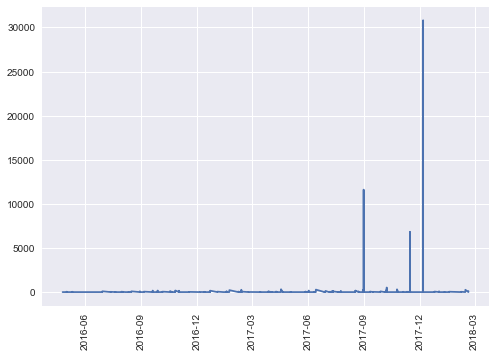

In [17]:
### Check for outliers, i.e see any adnormal spikes that may indicate data error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

df = df.sort_values('Date/Time', ascending=True)
plt.plot(df['Date/Time'], df['Duration'])
plt.xticks(rotation='vertical')
plt.show()

In [18]:
### Another view to check for outliers details that has duration > 1 day (1440 durations), 
### which may indicate data error

count=0
outlier_list=[]
for index in range(len(df)):
    #if df.Duration[index].days >=  1:
    if int(df.Duration[index]) >=  1440:  # 1440 = 24 hours
        print ('Disruption >1 day (1440 minutes) at index %s: %s, %s, %s' % (index, df.Duration[index], df['Date/Time'][index], df.MRT_Line[index]))
        count = count + 1
        outlier_list.append(index)  # store the outlier index

print("Count of disruption >1 day (1440 minutes): %s" % count)
print(outlier_list)

### Sort the outlier index
outlier_list.sort()
outlier_list=outlier_list[::-1]
print(outlier_list)

Disruption >1 day (1440 minutes) at index 97: 30816.0, 2017-12-06 14:05:00, EWL
Disruption >1 day (1440 minutes) at index 107: 6840.0, 2017-11-15 01:15:00, EWL
Disruption >1 day (1440 minutes) at index 403: 11615.0, 2017-08-31 03:55:00, NSL
Count of disruption >1 day (1440 minutes): 3
[97, 107, 403]
[403, 107, 97]


In [19]:
### Remove outliers from the dataframe after investigating the data.

for i in outlier_list:
    print("Removing data at index %s." % i)
    df = df[df.index!= i]

Removing data at index 403.
Removing data at index 107.
Removing data at index 97.


In [20]:
### Check if outlier rows has been deleted
df.shape

(580, 10)

In [21]:
### Re-Sort the MRT Line and Date/time after removing outliers
df.sort_values(['MRT_Line', 'Date/Time'], ascending=[True, False], inplace=True)
df.head()

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn,Duration,New_Fr_Stn,New_To_Stn
0,[BPLRT] Fault cleared. Normal train services a...,12:54 AM - 18 Jan 2018,2018-01-18 00:54:00,BPLRT,cleared,None,None,42,ChoaChuKang,Phoenix
1,[BPLRT]: No train service between #ChoaChuKang...,12:12 AM - 18 Jan 2018,2018-01-18 00:12:00,BPLRT,update,ChoaChuKang,Phoenix,0,None,None
2,[BPLRT] CLEARED: Free regular and bridging bus...,3:09 AM - 12 Jan 2018,2018-01-12 03:09:00,BPLRT,cleared,None,None,0,None,None
3,[BPLRT] UPDATE: Train services on the entire B...,2:30 AM - 12 Jan 2018,2018-01-12 02:30:00,BPLRT,cleared,None,None,0,None,None
4,[BPLRT] UPDATE: Service B on the BPLRT inner l...,2:04 AM - 12 Jan 2018,2018-01-12 02:04:00,BPLRT,cleared,None,None,0,None,None


In [22]:
### Compute the average disruption duration
count=0
total=0
for index in range(len(df)):
    if index in outlier_list: pass
    elif int(df.Duration[index]) > 0:
        total = total + int(df.Duration[index])
        count = count + 1
        datetime = df['Date/Time'][index]
        #print(index)

average = total/count

print('Number of disruption since %s                 : %s' % (datetime, count))
print("Average SMRT Line disruption duration since %s: %.2f minutes" % (datetime, average))

Number of disruption since 2016-05-11 01:41:00                 : 114
Average SMRT Line disruption duration since 2016-05-11 01:41:00: 75.33 minutes


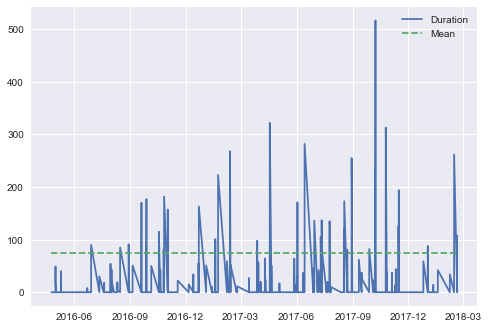

In [23]:
### Plot disruption duration (in minutes) against date/time with mean

df = df.sort_values('Date/Time', ascending=True)

y_mean = [average for i in df['Date/Time']]

plt.plot(df['Date/Time'], df['Duration'])
plt.plot(df['Date/Time'], y_mean, label='Mean', linestyle='--')

legend = plt.legend(loc='best')  # insert a legend

plt.show()

In [24]:
### Prepare dataset for analysing relationship between number of tweets and disruption
### ==================================================================================

### Remove all non-'cleared' status

df2 = df[df.Status != 'update']
df2.head(10)   

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn,Duration,New_Fr_Stn,New_To_Stn
83,[CCL] Normal services have resumed. Free shutt...,6:23 AM - 25 Apr 2016,2016-04-25 06:23:00,CCL,cleared,None,None,0,None,None
82,[CCL] Normal services have resumed. Free shutt...,6:31 AM - 25 Apr 2016,2016-04-25 06:31:00,CCL,cleared,None,None,0,None,None
32,[BPLRT] Train services have resumed on the BPL...,6:52 AM - 25 Apr 2016,2016-04-25 06:52:00,BPLRT,cleared,None,None,0,None,None
31,[BPLRT] Train services have resumed on BPLRT. ...,7:12 AM - 25 Apr 2016,2016-04-25 07:12:00,BPLRT,cleared,None,None,0,None,None
30,[BPLRT] Free shuttle bus services have ceased.,7:16 AM - 25 Apr 2016,2016-04-25 07:16:00,BPLRT,cleared,None,None,0,None,None
580,[NSL] CLEARED: Train service from #Kranji to #...,3:49 PM - 25 Apr 2016,2016-04-25 15:49:00,NSL,cleared,None,None,0,None,None
579,[NSL]CLEARED: Free public & shuttle buses are ...,3:51 PM - 25 Apr 2016,2016-04-25 15:51:00,NSL,cleared,None,None,0,None,None
578,[NSL]Fault cleared but some trains & stations ...,4:20 PM - 25 Apr 2016,2016-04-25 16:20:00,NSL,cleared,None,None,0,None,None
577,[NSL] CLEARED: Train services between Kranji a...,4:29 PM - 25 Apr 2016,2016-04-25 16:29:00,NSL,cleared,None,None,0,None,None
333,[EWL] CLEARED: Train service has resumed betwe...,1:33 AM - 2 May 2016,2016-05-02 01:33:00,EWL,cleared,None,None,49,JooKoon,BoonLay


In [25]:
### Check data type

df['Duration'] = df['Duration'].astype(int)
df.dtypes

Tweet                          object
Extracted Date/Time            object
Date/Time              datetime64[ns]
MRT_Line                       object
Status                         object
From_Stn                       object
To_Stn                         object
Duration                        int64
New_Fr_Stn                     object
New_To_Stn                     object
dtype: object

In [26]:
### Remove duration=0 and put the clean up data into a new dataframe
df2 = df[df.Duration != 0]
df2.head(10)

,Tweet,Extracted Date/Time,Date/Time,MRT_Line,Status,From_Stn,To_Stn,Duration,New_Fr_Stn,New_To_Stn
333,[EWL] CLEARED: Train service has resumed betwe...,1:33 AM - 2 May 2016,2016-05-02 01:33:00,EWL,cleared,None,None,49,JooKoon,BoonLay
331,[EWL] CLEARED: Free regular bus service betwee...,1:53 AM - 2 May 2016,2016-05-02 01:53:00,EWL,cleared,None,None,16,JooKoon,BoonLay
572,[NSL] CLEARED: Train services from #Yishun tow...,1:41 AM - 11 May 2016,2016-05-11 01:41:00,NSL,cleared,None,None,40,Yishun,Yio
569,[NSL]UPDATE:Train service from Woodlands to Se...,1:53 AM - 23 Jun 2016,2016-06-23 01:53:00,NSL,cleared,None,None,8,Woodlands,Sembawang
563,[NSL] CLEARED: Normal train service from #YioC...,7:49 AM - 29 Jun 2016,2016-06-29 07:49:00,NSL,cleared,None,None,90,Woodlands,AngMoKio
561,[NSL] UPDATE: South Bound normal service resum...,8:22 PM - 12 Jul 2016,2016-07-12 20:22:00,NSL,cleared,None,None,10,Bishan,Khatib
559,[NSL] CLEARED: Normal train service from #Bish...,9:07 PM - 12 Jul 2016,2016-07-12 21:07:00,NSL,cleared,None,None,30,Bishan,Khatib
555,[NSL] CLEARED: Train service between #MarinaBa...,5:02 PM - 20 Jul 2016,2016-07-20 17:02:00,NSL,cleared,None,None,18,MarinaBay,MarinaSouthPier
327,"[EWL] Update: Fault has been cleared. However,...",2:48 AM - 31 Jul 2016,2016-07-31 02:48:00,EWL,cleared,None,None,54,Bugis,PasirRis
550,[NSL] CLEARED: Train service on the NSL has re...,6:19 PM - 1 Aug 2016,2016-08-01 18:19:00,NSL,cleared,None,None,21,Yishun,Woodlands


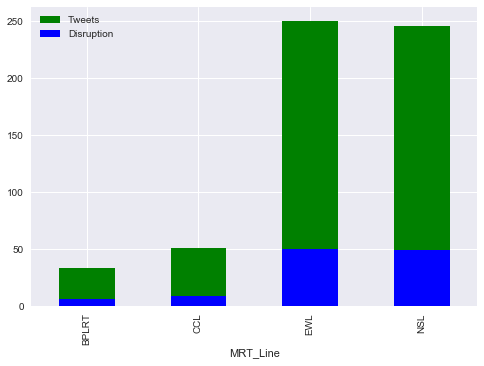

In [27]:
### Plot the relationship between tweets and disruption data
fig = plt.figure()
ax = plt.subplot(111)

df.groupby('MRT_Line').Status.count().plot(kind='bar', ax=ax, label='Tweets', color='g')
df2.groupby('MRT_Line').Status.count().plot(kind='bar', ax=ax, label='Disruption', color='b')

legend = plt.legend(loc='best')

In [28]:
### Prepare a new dataframe for disruption analysis
df3 = pd.DataFrame()
df3['MRT_Line'] = df2['MRT_Line']
df3['hours'] = df2['Date/Time'].dt.hour
df3['duration'] = df2['Duration']
df3['Date/Time'] = df2['Date/Time']
df3.head(10)

,MRT_Line,hours,duration,Date/Time
333,EWL,1,49,2016-05-02 01:33:00
331,EWL,1,16,2016-05-02 01:53:00
572,NSL,1,40,2016-05-11 01:41:00
569,NSL,1,8,2016-06-23 01:53:00
563,NSL,7,90,2016-06-29 07:49:00
561,NSL,20,10,2016-07-12 20:22:00
559,NSL,21,30,2016-07-12 21:07:00
555,NSL,17,18,2016-07-20 17:02:00
327,EWL,2,54,2016-07-31 02:48:00
550,NSL,18,21,2016-08-01 18:19:00


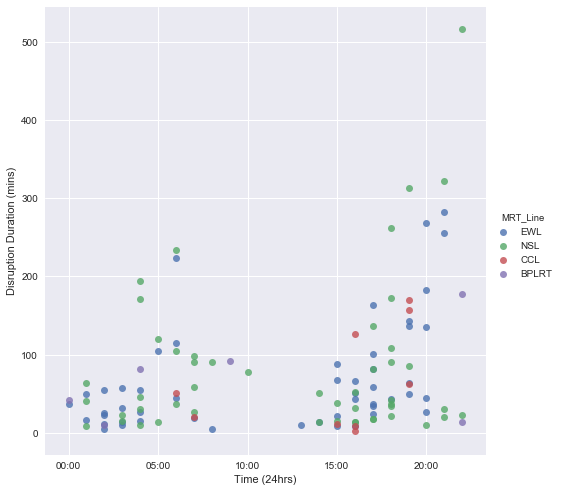

In [29]:
### Analyse the MRT service breakdown ocurrence 

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

xFormatter = FormatStrFormatter('%02d:00')

snsplot = sns.lmplot('hours', 'duration', data=df3, hue='MRT_Line', fit_reg=False, size=7) #remove col='MRT_Line' to get a combine view, 
snsplot.set(xlabel = "Time (24hrs)", ylabel = "Disruption Duration (mins)")#, title = "Disruption Plot")

axes = snsplot.ax
axes.xaxis.set_major_formatter(xFormatter)

plt.show()

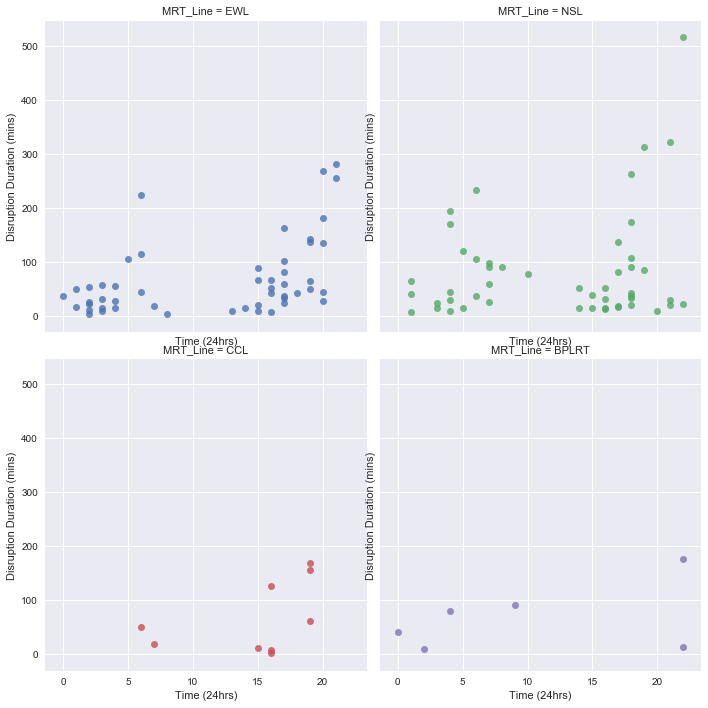

In [30]:
### Plot disruption occurence chart for each MRT Line separately

xFormatter = FormatStrFormatter('%02d:00')

snsplot = sns.lmplot('hours', 'duration', data=df3, hue='MRT_Line', col='MRT_Line', col_wrap=2, fit_reg=False, size=5) #remove col='MRT_Line' to get a combine view
#sharex=True, sharey=True, 
snsplot.set(xlabel = "Time (24hrs)", ylabel = "Disruption Duration (mins)")#, title = "Disruption Plot")

plt.show()


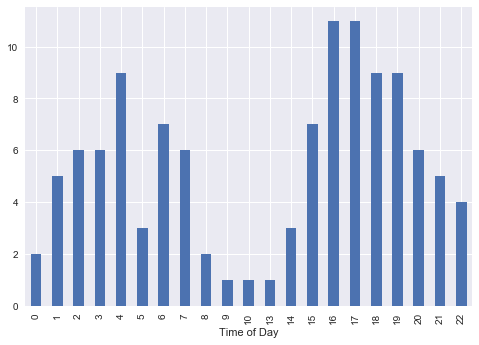

In [31]:
### Frequency of service disruption across time (hourly) of day
fig, ax = plt.subplots()
df3.groupby('hours').MRT_Line.count().plot.bar()
ax.set_xlabel("Time of Day")

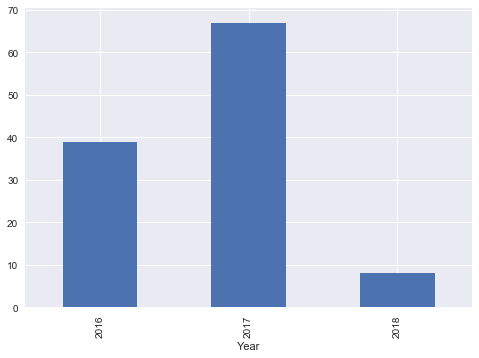

In [32]:
### Yearly frequency of service disruption
fig, ax = plt.subplots()
df3.groupby(df3['Date/Time'].dt.year).MRT_Line.count().plot.bar()
ax.set_xlabel("Year")

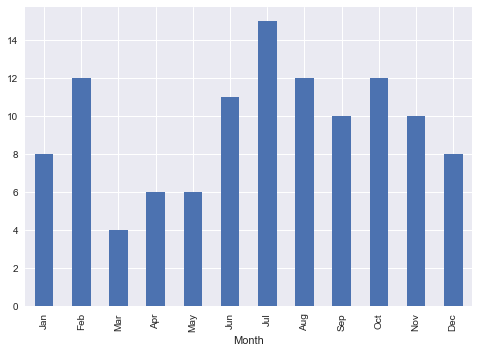

In [35]:
### Monthly frequency of service disruption

mths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots()
df3.groupby(df3['Date/Time'].dt.month).MRT_Line.count().plot.bar()
ax.set_xlabel("Month")
ax.set_xticklabels([mths[i] for i in range(12)])

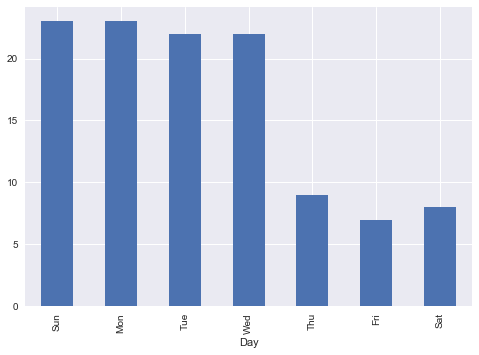

In [36]:
### Day of week daily frequency of service disruption

days=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']

fig, ax = plt.subplots()
df3.groupby(df3['Date/Time'].dt.dayofweek).MRT_Line.count().plot.bar()

ax.set_xlabel("Day")
ax.set_xticklabels([days[i] for i in range(7)])

In [37]:
browser.quit()